In [56]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from os import path

# Sensivity analysis when we change Latency

# Inputs
load = [100, 700], # load
capacity = [0, 500], # capacity
latency = [10, 80], # latency
availability = [0, 1], # availability

# Model Inputs
problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newLatency'],
    'bounds': [
                load,
                capacity,
                latency,
                availability,
                latency
               ]
}

# Suggesting N = 1000
param_values = saltelli.sample(problem, 100)

sensitivity_path = path.join("..", "out", "sensitivity")
param_file_path = path.join(sensitivity_path, "param_values.txt")
print("saving", param_file_path)
np.savetxt(param_file_path, param_values, fmt='%1.4f')



saving ../out/sensitivity/param_values.txt


Questions To Ask
- Do we want to have this model accept some combination of degradations at the same time or just one?
    > Limit it to just one degradation at a time
- Some scenarios have different architecture? Z has unlimited capacity in most scenarios.
    > I think we need 1 "model" per architecture. Also means, we may need to consider different input distributions per scenario, since they would each be a situation (i.e. we care about latency in this one, so our latency distribution is wider, etc)
- `TICK_DILATION` and output values? How does this affect our sensitivity if we report latency as actual latency scaled by the dilation value?
    > I think we need to care about magnitude here, since the Y axis for sensitivity is this magnitude value.
    

In [49]:
# Outputs from Time Series
""" Some assistance from this article
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
"""

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def time_series_crosscorr(d1, d2, window):
    """
    Returns crosscorr, delay
    """
    #rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]
    rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]

    # Early exit if no window
    if window == 0:
        #print(window, 0, rs)
        return rs[0], 0
    
    maxCrossCorr = np.amax(rs)
    maxCrossCorrIndex = np.argmax(rs)
    minCrossCorr = np.amin(rs)
    minCrossCorrIndex = np.argmin(rs)

    actualCrossCorr = 0
    actualCrossCorrIndex = 0

    if maxCrossCorr > -1 * minCrossCorr:
        actualCrossCorr = maxCrossCorr
        actualCrossCorrIndex = maxCrossCorrIndex
    else:
        actualCrossCorr = minCrossCorr
        actualCrossCorrIndex = minCrossCorrIndex

    offset = -window + actualCrossCorrIndex
    #print(window, actualCrossCorrIndex, rs)

    return actualCrossCorr, offset

def ending_n_mean(datay, n):
    return np.mean(datay[-n:])

def ending_n_slope(datay, n):
    return (datay.iloc[-1] - datay.iloc[-n]) / n

In [58]:
import glob
import pandas as pd
import re

def get_output(series):
    loadX = series["loadFromX"]

    ending_n = 15

    # LoadX - LoadY
    loadY = series["loadFromY"]
    c_loadx_loady = crosscorr(loadX, loadY)
    tc_loadx_loady, offset_loadx_loady = time_series_crosscorr(loadX, loadY, 6)
    em_loadx_loady = ending_n_mean(loadY, ending_n)
    es_loadx_loady = ending_n_slope(loadY, ending_n)

    
    # LoadX - LatY
    latY = series["meanLatencyFromY"]
    c_loadx_laty = crosscorr(loadX, latY)
    tc_loadx_laty, offset_loadx_laty = time_series_crosscorr(loadX, latY, 6)
    em_loadx_laty = ending_n_mean(latY, ending_n)
    es_loadx_laty = ending_n_slope(latY, ending_n)

    return [
        c_loadx_loady, tc_loadx_loady, offset_loadx_loady, em_loadx_loady, es_loadx_loady,
        c_loadx_laty, tc_loadx_laty, offset_loadx_laty, em_loadx_laty, es_loadx_laty
        ]


#time_series_path = path.join("..", "out", "sensitivity", "results-1627078635970")
time_series_path = path.join("..", "out", "sensitivity", "results-1627332603267")
time_series_file_name_pattern = path.join(time_series_path, "*.csv")
all_time_series_csv_files = glob.glob(time_series_file_name_pattern)

# sort by the id so each row still matches the id of the time series
sorted_time_series_files = sorted(all_time_series_csv_files, key=lambda x:float(re.findall("(\d+)\-.*\.csv",x)[0]))
time_series = [pd.read_csv(f) for f in sorted_time_series_files]
outputs = [get_output(s) for s in time_series]

# transpose so we can just write each column as a file with normal array access
transposed = np.transpose(outputs)
#single = transposed[1]
#print(outputs)
for index, o in enumerate(transposed):
    #print("saving", o)
    file_name = path.join(time_series_path, f"output_{index}_values.txt")
    np.savetxt(file_name, o, fmt='%1.8f')

Found Outputs: ['../out/sensitivity/results-1627332603267/output_6_values.txt', '../out/sensitivity/results-1627332603267/output_9_values.txt', '../out/sensitivity/results-1627332603267/output_4_values.txt', '../out/sensitivity/results-1627332603267/output_2_values.txt', '../out/sensitivity/results-1627332603267/output_0_values.txt', '../out/sensitivity/results-1627332603267/output_8_values.txt', '../out/sensitivity/results-1627332603267/output_7_values.txt', '../out/sensitivity/results-1627332603267/output_1_values.txt', '../out/sensitivity/results-1627332603267/output_5_values.txt', '../out/sensitivity/results-1627332603267/output_3_values.txt'] that matched ../out/sensitivity/results-1627332603267/output_*_values.txt


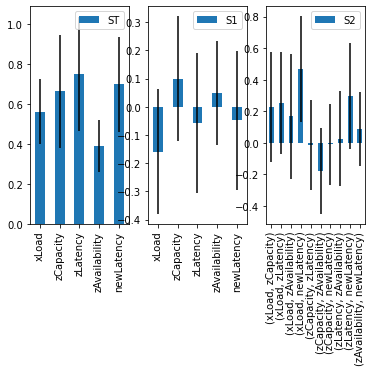

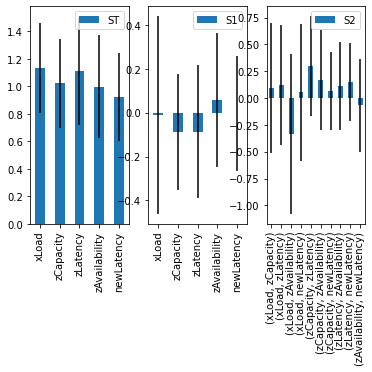

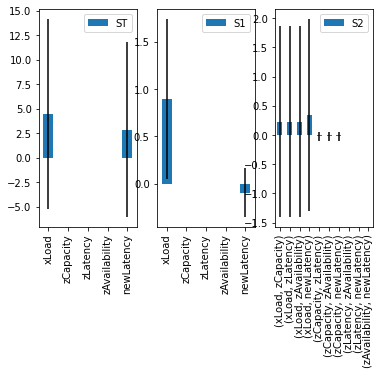

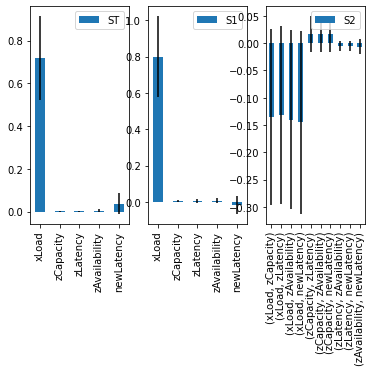

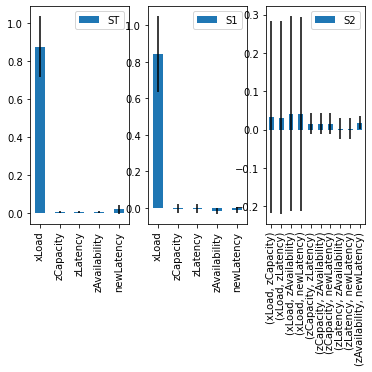

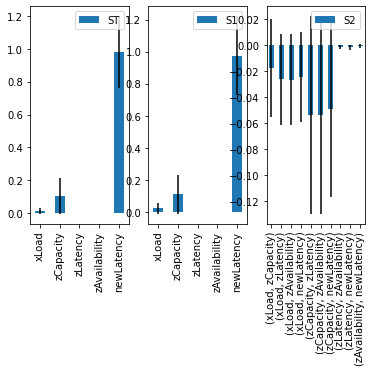

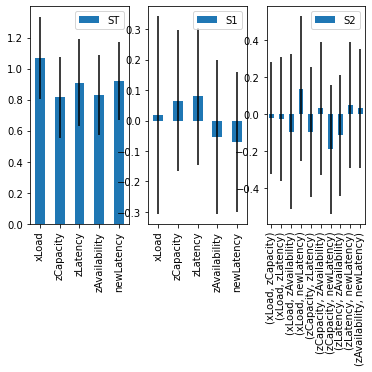

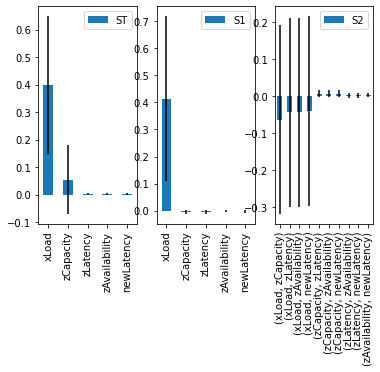

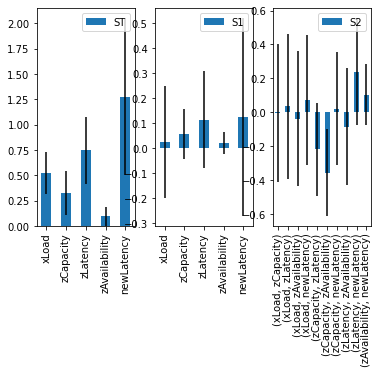

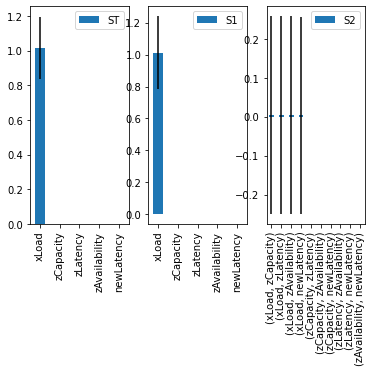

In [59]:
all_output_files_pattern = path.join(time_series_path, "output_*_values.txt")
all_output_files = glob.glob(all_output_files_pattern)
print("Found Outputs:", all_output_files, "that matched", all_output_files_pattern)


outputs = [np.loadtxt(f, float) for f in all_output_files]
converted = [np.nan_to_num(o) for o in outputs]
analysis = [sobol.analyze(problem, o) for o in converted]
for a in analysis:
    a.plot()
#print(analysis)


#Y = np.loadtxt(time_series_path + "\output_values.txt", float)
#Y = np.nan_to_num(Y)
#Si = sobol.analyze(problem, Y)
#print(Si)
#print(Si['S1'])
#print(Si['ST'])
#Si.plot()